# Tugas 3: Recurrent Neural Network

Silahkan dikerjakan di google colab dengan cara **File > Save a copy in Drive** notebook ini ke folder Colab Notebooks di drive pribadi Anda. Atau bisa dikerjakan di komputer yang sudah menginstall numpy 


Nama: Muhammad Irfan Junaidi

NPM: 1906293202

Referensi:

- https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html
- ...
- ...


Kerjakan bagian yang pada code yang ditandai dalam range **START TODO** sampai **END TODO**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Recurrent Neural Networks (RNN) sangat efektif untuk Natural Language Processing (NLP) dan data yang memiliki urutan karena RNN memiliki "memori". RNN dapat membaca input $x^{\langle t \rangle}$ (seperti kata-kata) satu per satu, dan mengingat beberapa informasi/konteks melalui *hidden layer activation* yang diteruskan dari satu langkah ke langkah berikutnya. Hal ini memungkinkan RNN *uni-directional* untuk mengambil informasi dari masa lalu untuk memproses input selanjutnya. RNN *bidirection* dapat mengambil konteks dari masa lalu dan masa depan.

**Notasi**:
- Superscript $[l]$ menunjukkan objek yang terkait dengan layer $l^{th}$.
     - Contoh: $a^{[4]}$ adalah *activation layer* ke-$4$. $W^{[5]}$ dan $b^{[5]}$ adalah parameter layer ke-$5$.

- Superscript $(i)$ menunjukkan objek yang terkait dengan contoh ke-$i$.
     - Contoh: $x^{(i)}$ adalah contoh *training input* ke-$i$.

- Superscript $\langle t \rangle$ menunjukkan objek pada langkah waktu ke-$t$.
     - Contoh: $x^{\langle t \rangle}$ adalah input x pada langkah waktu ke-$t$. $x^{(i)\langle t \rangle}$ adalah input pada langkah waktu ke-$t$ dari contoh $i$.
    
- Lowerscript $i$ menunjukkan entri ke-$i$ dari sebuah vektor.
     - Contoh: $a^{[l]}_i$ menunjukkan entri ke-$i$ dari aktivasi di layer $l$.

Mari kita mulai!

## Setup

Mari import dulu semua package yang Anda perlukan selama tugas ini.

In [2]:
import numpy as np

Berikut ini adalah fungsi-fungsi yang akan sering digunakan pada tugas ini

In [3]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s


def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)] 
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)] 

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (grads["dW" + str(l+1)] ** 2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (grads["db" + str(l+1)] ** 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2 ** t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / np.sqrt(s_corrected["dW" + str(l+1)] + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / np.sqrt(s_corrected["db" + str(l+1)] + epsilon)

    return parameters, v, s

## 1 - Forward propagation untuk Basic Recurrent Neural Network

Basic RNN yang akan Anda terapkan memiliki struktur di bawah ini. Dalam contoh ini, $T_x = T_y$.

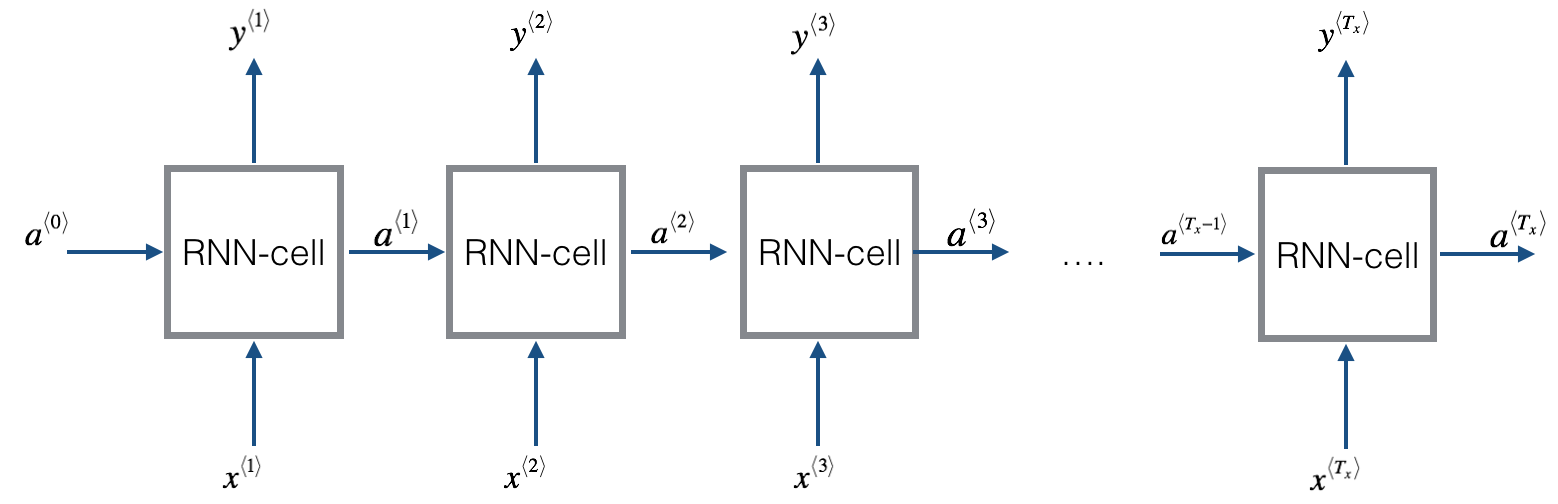
<caption><center> Gambar 1: Basic RNN model </center></caption>

Inilah cara Anda dapat menerapkan RNN:

**Langkah-langkah**:
1. Terapkan perhitungan yang dibutuhkan untuk satu langkah waktu RNN.
2. Terapkan loop pada $T_x$ time-steps untuk memproses semua input, satu per satu.

Ayo pergi!

## 1.1 - RNN cell

Recurrent Neural Network dapat dilihat sebagai pengulangan sel tunggal. Anda pertama-tama akan mengimplementasikan perhitungan untuk satu langkah waktu. Gambar berikut menjelaskan operasi untuk satu langkah waktu sel RNN.

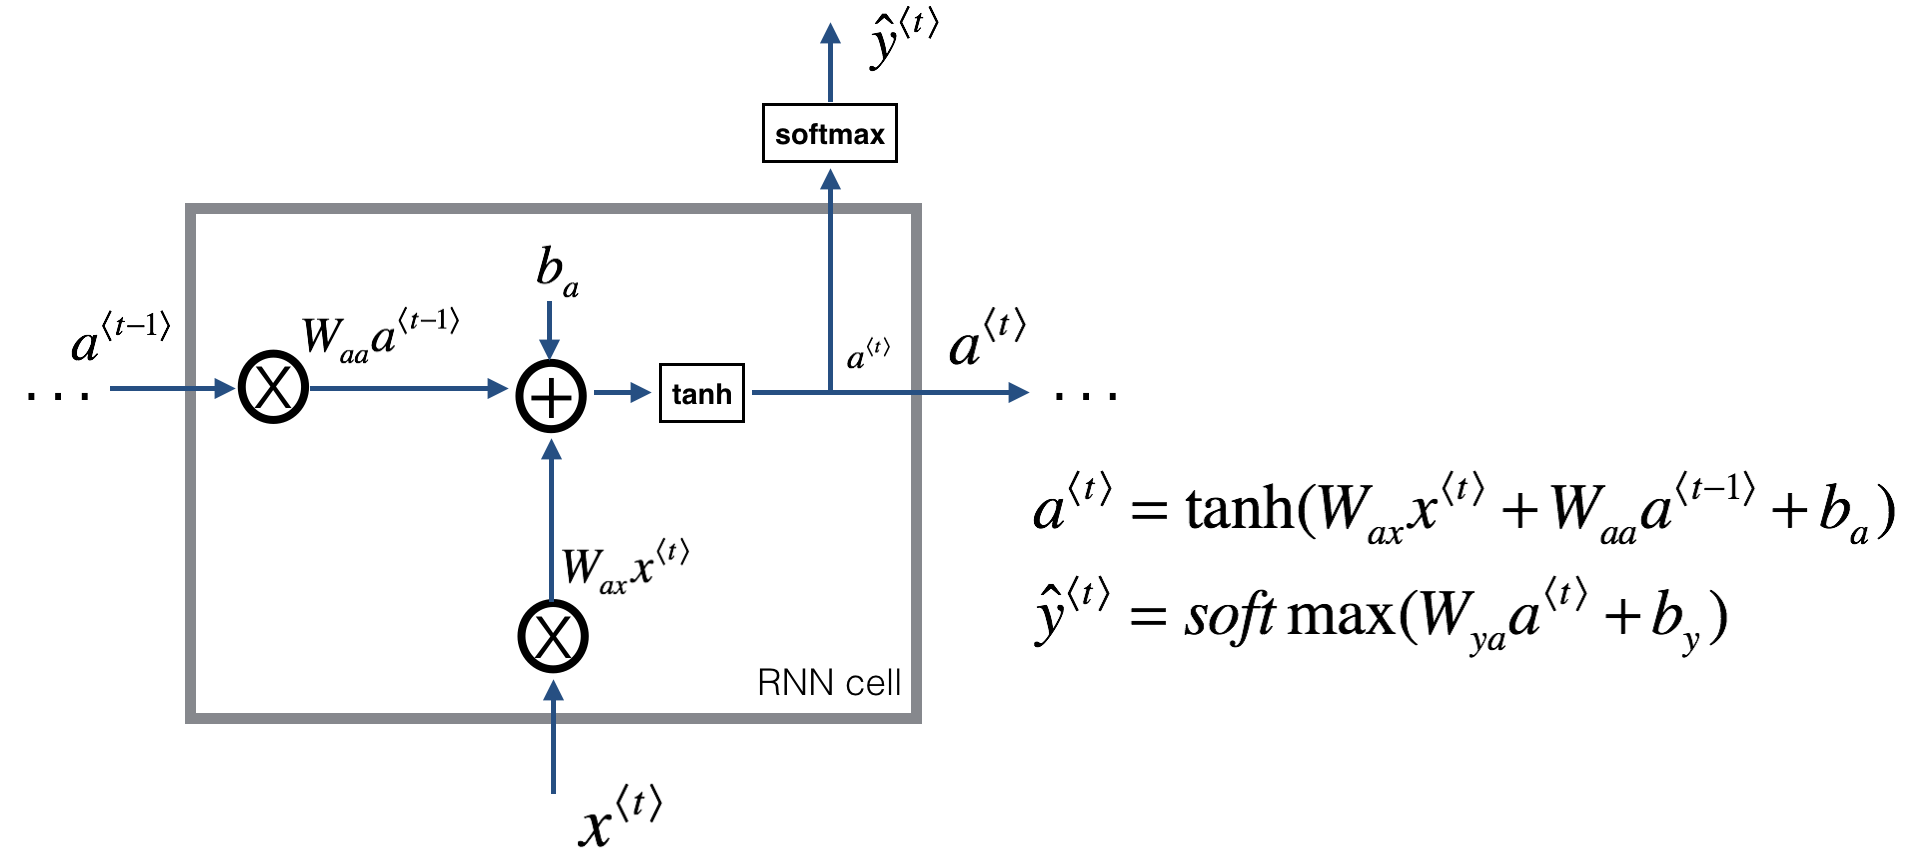


<caption><center>

**Gambar 2**: Sel RNN dasar. Mengambil sebagai input $x^{\langle t \rangle}$ (input saat ini) dan $a^{\langle t - 1\rangle}$ (keadaan tersembunyi sebelumnya yang berisi informasi dari masa lalu), dan menghasilkan $a^{\ langle t \rangle}$ yang diberikan ke sel RNN berikutnya dan juga digunakan untuk memprediksi $y^{\langle t \rangle}$

</center></caption>

**Latihan**: Menerapkan sel RNN yang dijelaskan pada Gambar (2).

**Petunjuk**:
1. Hitung keadaan tersembunyi dengan aktivasi tanh: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Menggunakan status tersembunyi baru Anda $a^{\langle t \rangle}$, hitung prediksi $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \ rentang} + b_y)$. Kami sudah menyediakan Anda sebuah fungsi: `softmax`.
3. Simpan $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameter)$ dalam cache
4. Kembalikan $a^{\langle t \rangle}$ , $y^{\langle t \rangle}$ dan cache

Kami akan membuat vektor lebih dari $m$ contoh. Jadi, $x^{\langle t \rangle}$ akan berdimensi $(n_x,m)$, dan $a^{\langle t \rangle}$ akan berdimensi $(n_a,m)$.

In [4]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    ### START TODO ### (≈2 lines)
    # compute next activation state using the formula given above
    a_next = np.tanh(np.matmul(Waa, a_prev) + np.matmul(Wax, xt) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.matmul(Wya, a_next) + by)
    ### END TODO ###
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [5]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a_next, yt_pred, cache = rnn_cell_forward(xt, a_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", a_next.shape)
print("yt_pred[1] =", yt_pred[1])
print("yt_pred.shape = ", yt_pred.shape)

a_next[4] =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =  (5, 10)
yt_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape =  (2, 10)


**Expected Output**: 

<table>
    <tr>
        <td>
            <b>a_next[4]</b>:
        </td>
        <td>
           [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
        </td>
    </tr>
        <tr>
        <td>
            <b>a_next.shape</b>:
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>yt[1]</b>:
        </td>
        <td>
           [ 0.9888161   0.01682021  0.21140899  0.36817467  0.98988387  0.88945212
  0.36920224  0.9966312   0.9982559   0.17746526]
        </td>
    </tr>
        <tr>
        <td>
            <b>yt.shape</b>:
        </td>
        <td>
           (2, 10)
        </td>
    </tr>

</table>

## 1.2 - RNN forward pass 

Anda dapat melihat RNN sebagai sel berulang yang baru saja Anda buat. Jika urutan input data Anda dilakukan lebih dari 10 langkah waktu, maka Anda akan menyalin sel RNN 10 kali. Setiap sel mengambil sebagai input *hidden state* dari sel sebelumnya ($a^{\langle t-1 \rangle}$) dan data input langkah waktu saat ini ($x^{\langle t \rangle}$). Ini menampilkan *hidden state* ($a^{\langle t \rangle}$) dan prediksi ($y^{\langle t \rangle}$) untuk langkah waktu ini.


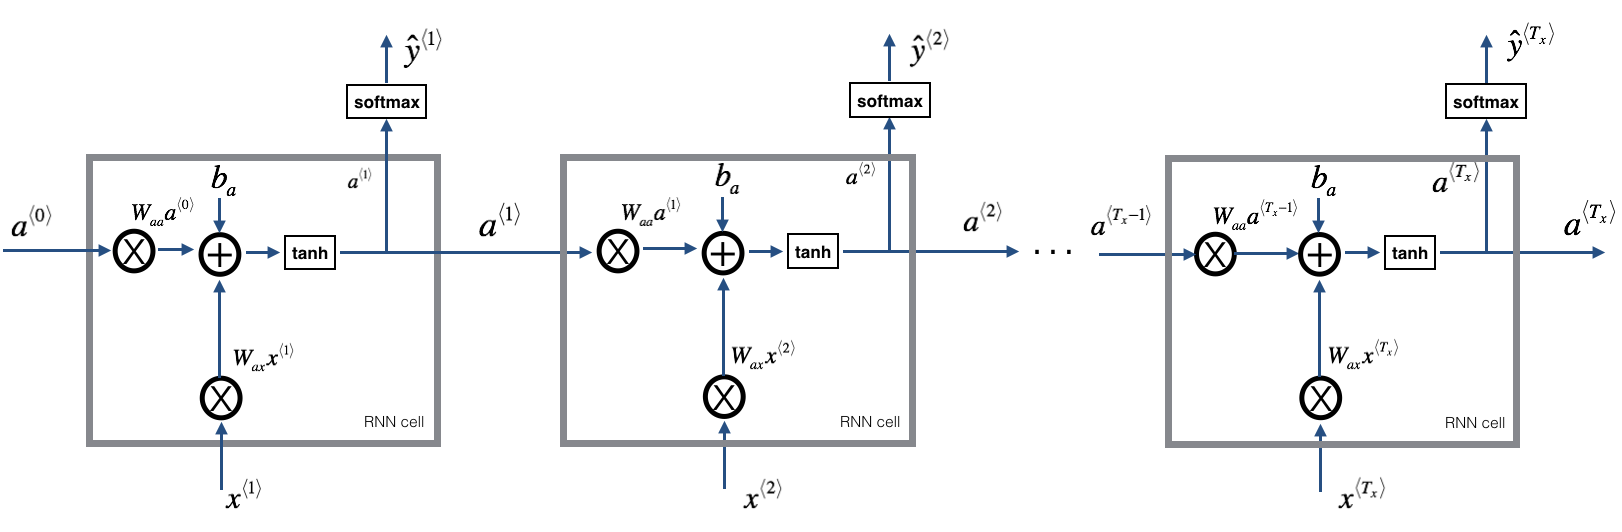


<caption><center>

**Gambar 3**: Basic RNN. Urutan input $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ dibawa melalui $T_x$ langkah waktu . RNN mengeluarkan $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$.

</center></caption>



**Latihan**: Kode forward propagation dari RNN yang dijelaskan pada Gambar (3).

**Petunjuk**:
1. Buat vektor nol ($a$) yang akan menyimpan semua *hidden state* yang dihitung oleh RNN.
2. Inisialisasi *hidden state* "berikutnya" sebagai $a_0$ (*hidden state* awal).
3. Mulai mengulang setiap langkah waktu, indeks inkremental Anda adalah $t$ :
    - Perbarui *hidden state* "berikutnya" dan cache dengan menjalankan `rnn_cell_forward`
    - Simpan *hidden state* "berikutnya" di posisi $a$ ($t^{th}$)
    - Simpan prediksi di y
    - Tambahkan cache ke daftar cache
4. Kembalikan $a$, $y$ dan cache

In [6]:
def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and Wy
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    ### START TODO ###
    
    # initialize "a" and "y" with zeros (≈2 lines)
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    
    # Initialize a_next (≈1 line)
    a_next = a0
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, compute the prediction, get the cache (≈1 line)
        a_next, yt_pred, cache = rnn_cell_forward(x[:, :, t], a_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:, :, t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y_pred[:, :, t] = yt_pred
        # Append "cache" to "caches" (≈1 line)
        caches.append(cache)
        
    ### END TODO ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)
    
    return a, y_pred, caches

In [7]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a, y_pred, caches = rnn_forward(x, a0, parameters)
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))

a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


**Expected Output**:

<table>
    <tr>
        <td>
            <b>a[4][1]</b>:
        </td>
        <td>
           [-0.99999375  0.77911235 -0.99861469 -0.99833267]
        </td>
    </tr>
        <tr>
        <td>
            <b>a.shape</b>:
        </td>
        <td>
           (5, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            <b>y[1][3]</b>:
        </td>
        <td>
           [ 0.79560373  0.86224861  0.11118257  0.81515947]
        </td>
    </tr>
        <tr>
        <td>
            <b>y.shape</b>:
        </td>
        <td>
           (2, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            <b>cache[1][1][3]</b>:
        </td>
        <td>
           [-1.1425182  -0.34934272 -0.20889423  0.58662319]
        </td>
    </tr>
        <tr>
        <td>
            <b>len(cache)</b>:
        </td>
        <td>
           2
        </td>
    </tr>

</table>

Selamat! Anda telah berhasil membangun *forward propagation RNN from scratch*. Ini akan bekerja cukup baik untuk beberapa aplikasi, tetapi mengalami masalah *vanishing gradient*. Jadi ini bekerja paling baik ketika setiap output $y^{\langle t \rangle}$ dapat diperkirakan menggunakan konteks "lokal" terutama (artinya informasi dari input $x^{\langle t' \rangle}$ di mana $t'$ berada tidak terlalu jauh dari $t$).

Di bagian selanjutnya, Anda akan membangun model LSTM yang lebih kompleks, yang lebih baik dalam menangani *vanishing gradient*. LSTM akan lebih mampu mengingat sepotong informasi dan menyimpannya untuk banyak langkah waktu.

## 2 - Long Short-Term Memory (LSTM) network

Gambar berikut ini menunjukkan operasi sel LSTM.


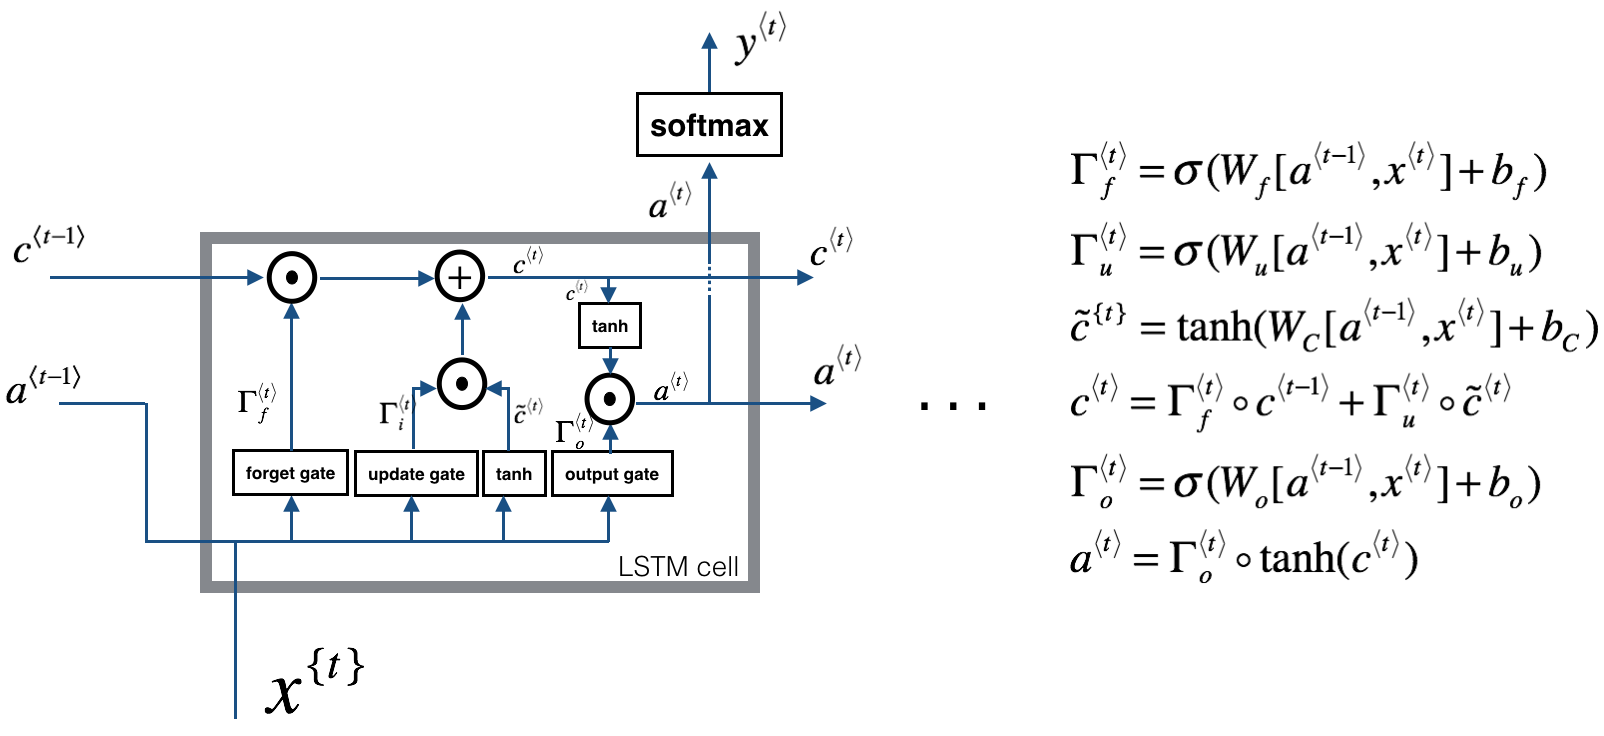


<caption><center>

**Gambar 4**: LSTM-cell. Sel ini melacak dan memperbarui "keadaan sel" atau variabel memori $c^{\langle t \rangle}$ pada setiap langkah waktu, yang dapat berbeda dari $a^{\langle t \rangle}$.

</center></caption>

Mirip dengan contoh RNN di atas, Anda akan mulai dengan mengimplementasikan sel LSTM untuk satu langkah waktu. Kemudian Anda dapat memanggilnya berulang-ulang dari dalam for-loop untuk membuatnya memproses input dengan $T_x$ time-steps.

### Tentang gates pada LSTM

#### - Forget gate

Demi ilustrasi ini, mari kita asumsikan kita sedang membaca kata-kata dalam sepotong teks, dan ingin menggunakan LSTM untuk melacak struktur tata bahasa, seperti apakah subjeknya tunggal atau jamak. Jika subjek berubah dari kata tunggal menjadi kata jamak, kita perlu menemukan cara untuk menghilangkan nilai memori yang tersimpan sebelumnya dari keadaan tunggal/jamak. Dalam LSTM, gerbang lupa memungkinkan kita melakukan ini:

$$\Gamma_f^{\langle t \rangle} = \sigma(W_f[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_f)\tag{1} $$

Di sini, $W_f$ adalah bobot yang mengatur perilaku *forget gate*. Kami menggabungkan $[a^{\langle t-1 \rangle}, x^{\langle t \rangle}]$ dan mengalikannya dengan $W_f$. Persamaan di atas menghasilkan vektor $\Gamma_f^{\langle t \rangle}$ dengan nilai antara 0 dan 1. Vektor lupa gerbang ini akan dikalikan elemen-bijaksana dengan keadaan sel sebelumnya $c^{\langle t-1 \rangle}$. Jadi jika salah satu nilai dari $\Gamma_f^{\langle t \rangle}$ adalah 0 (atau mendekati 0) maka itu berarti LSTM harus menghapus informasi tersebut (misalnya subjek tunggal) dalam komponen yang sesuai dari $c^{\langle t-1 \rangle}$. Jika salah satu nilainya adalah 1, maka informasi tersebut akan disimpan.

#### - Update gate

Begitu RNN "lupa" bahwa subjek yang sedang dibahas adalah tunggal, kita perlu menemukan cara untuk meng-update untuk mencerminkan bahwa subjek baru sekarang jamak. Berikut adalah rumus untuk *update gate*:

$$\Gamma_u^{\langle t \rangle} = \sigma(W_u[a^{\langle t-1 \rangle}, x^{\{t\}}] + b_u)\tag{2} $$

Mirip dengan *forget gate*, di sini $\Gamma_u^{\langle t \rangle}$ adalah lagi vektor nilai antara 0 dan 1. Ini akan dikalikan dengan elemen dengan $\tilde{c}^{\langle t \ rangle}$, untuk menghitung $c^{\langle t \rangle}$.

#### - Updating the cell

Untuk meng-update subjek baru, kita perlu membuat vektor angka baru yang dapat kita tambahkan ke status sel sebelumnya. Persamaan yang kita gunakan adalah:

$$ \tilde{c}^{\langle t \rangle} = \tanh(W_c[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_c)\tag{3 } $$

Akhirnya, state dari sel baru adalah:

$$ c^{\langle t \rangle} = \Gamma_f^{\langle t \rangle}* c^{\langle t-1 \rangle} + \Gamma_u^{\langle t \rangle} *\tilde{c }^{\langle t \rangle} \tag{4} $$


#### - Output gate

Untuk memutuskan output mana yang akan kita gunakan, kita akan menggunakan dua rumus berikut:

$$ \Gamma_o^{\langle t \rangle}= \sigma(W_o[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_o)\tag{5}$$
$$ a^{\langle t \rangle} = \Gamma_o^{\langle t \rangle}* \tanh(c^{\langle t \rangle})\tag{6} $$

Di mana dalam persamaan 5 Anda memutuskan apa yang akan dihasilkan menggunakan fungsi sigmoid dan dalam persamaan 6 Anda mengalikannya dengan $\tanh$ dari keadaan sebelumnya.

### 2.1 - LSTM cell

**Latihan**: Menerapkan sel LSTM yang dijelaskan pada Gambar (3).

**Petunjuk**:
1. Menggabungkan $a^{\langle t-1 \rangle}$ dan $x^{\langle t \rangle}$ dalam satu matriks: $concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$
2. Hitung semua rumus 1-6. Anda dapat menggunakan `sigmoid()` (disediakan) dan `np.tanh()`.
3. Hitung prediksi $y^{\langle t \rangle}$. Anda dapat menggunakan `softmax()` (disediakan).

In [8]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START TODO ###
    # Concatenate a_prev and xt (≈3 lines)
    concat_ax = np.concatenate([a_prev, xt])

    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ft = sigmoid(np.matmul(Wf, concat_ax) + bf)
    it = sigmoid(np.matmul(Wi, concat_ax) + bi)
    cct = np.tanh(np.matmul(Wc, concat_ax) + bc)
    c_next = np.multiply(ft, c_prev) + np.multiply(it, cct)
    ot = sigmoid(np.matmul(Wo, concat_ax) + bo)
    a_next = np.multiply(ot, np.tanh(c_next))
    
    # Compute prediction of the LSTM cell (≈1 line)
    yt_pred = softmax(np.matmul(Wy, a_next) + by)
    ### END TODO ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [9]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", c_next.shape)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))

a_next[4] =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] = [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


**Expected Output**:

<table>
    <tr>
        <td>
            <b>a_next[4]</b>:
        </td>
        <td>
           [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
        </td>
    </tr>
        <tr>
        <td>
            <b>a_next.shape</b>:
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>c_next[2]</b>:
        </td>
        <td>
           [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
        </td>
    </tr>
        <tr>
        <td>
            <b>c_next.shape</b>:
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>yt[1]</b>:
        </td>
        <td>
           [ 0.79913913  0.15986619  0.22412122  0.15606108  0.97057211  0.31146381
  0.00943007  0.12666353  0.39380172  0.07828381]
        </td>
    </tr>
        <tr>
        <td>
            <b>yt.shape</b>:
        </td>
        <td>
           (2, 10)
        </td>
    </tr>
    <tr>
        <td>
            <b>cache[1][3]</b>:
        </td>
        <td>
           [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
        </td>
    </tr>
        <tr>
        <td>
            <b>len(cache)</b>:
        </td>
        <td>
           10
        </td>
    </tr>

</table>

### 2.2 - Forward pass for LSTM

Sekarang setelah Anda menerapkan satu langkah dari LSTM, Anda sekarang dapat mengulanginya menggunakan for-loop untuk memproses urutan input $T_x$.


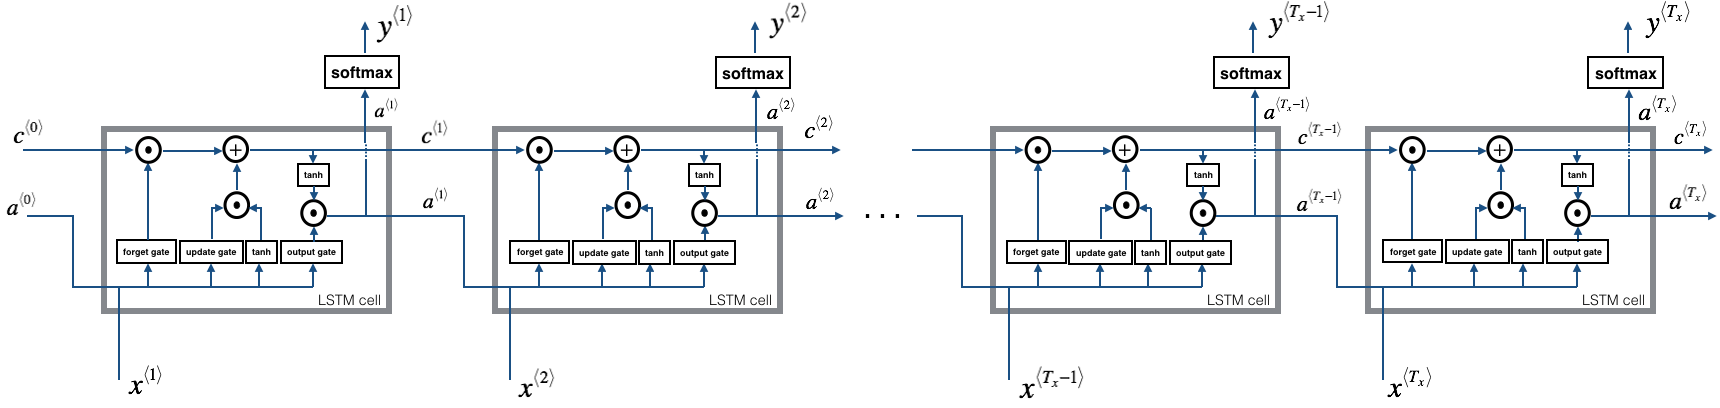

<caption><center>

**Gambar 4**: LSTM melalui beberapa langkah waktu.

</center></caption>

**Latihan:** Terapkan `lstm_forward()` untuk menjalankan LSTM lebih dari $T_x$ langkah waktu.

**Catatan**: $c^{\langle 0 \rangle}$ diinisialisasi dengan nol.

In [10]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### START TODO ###
    # Retrieve dimensions from shapes of x and Wy (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    
    # initialize "a", "c" and "y" with zeros (≈3 lines)
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))
    
    # Initialize a_next and c_next (≈2 lines)
    a_next = a0
    c_next = np.zeros((n_a, m))
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:, :, t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y[:, :, t] = yt
        # Save the value of the next cell state (≈1 line)
        c[:, :, t] = c_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)
        
    ### END TODO ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

In [11]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))

a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2


<b>Expected Output<b>:

<table>
    <tr>
        <td>
            <b>a[4][3][6]</b>
        </td>
        <td>
           0.172117767533
        </td>
    </tr>
    <tr>
        <td>
            <b>a.shape</b>
        </td>
        <td>
           (5, 10, 7)
        </td>
    </tr>
    <tr>
        <td>
            <b>y[1][4][3]</b>
        </td>
        <td>
           0.95087346185
        </td>
    </tr>
    <tr>
        <td>
            <b>y.shape</b>
        </td>
        <td>
           (2, 10, 7)
        </td>
    </tr>
    <tr>
        <td>
            <b>caches[1][1][1]</b>
        </td>
        <td>
           [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
        </td> 
    </tr>
    <tr>
        <td>
            <b>c[1][2][1]</b>
        </td>
        <td>
           -0.855544916718
        </td>
    </tr>  
    <tr>
        <td>
            <b>len(caches)</b>
        </td>
        <td>
           2
        </td>
    </tr>

</table>

## 3 - Backpropagation in recurrent neural networks

Sebelumnya Anda menerapkan Neural Network sederhana (*fully connected*), Anda menggunakan *backpropagation* untuk menghitung turunan sehubungan dengan cost untuk *update* parameter. Demikian pula, dalam RNN Anda dapat menghitung turunan sehubungan dengan *cost* untuk *update* parameter.

### 3.1 - Basic RNN  backward pass

Kita akan mulai dengan menghitung lintasan mundur untuk sel RNN dasar.

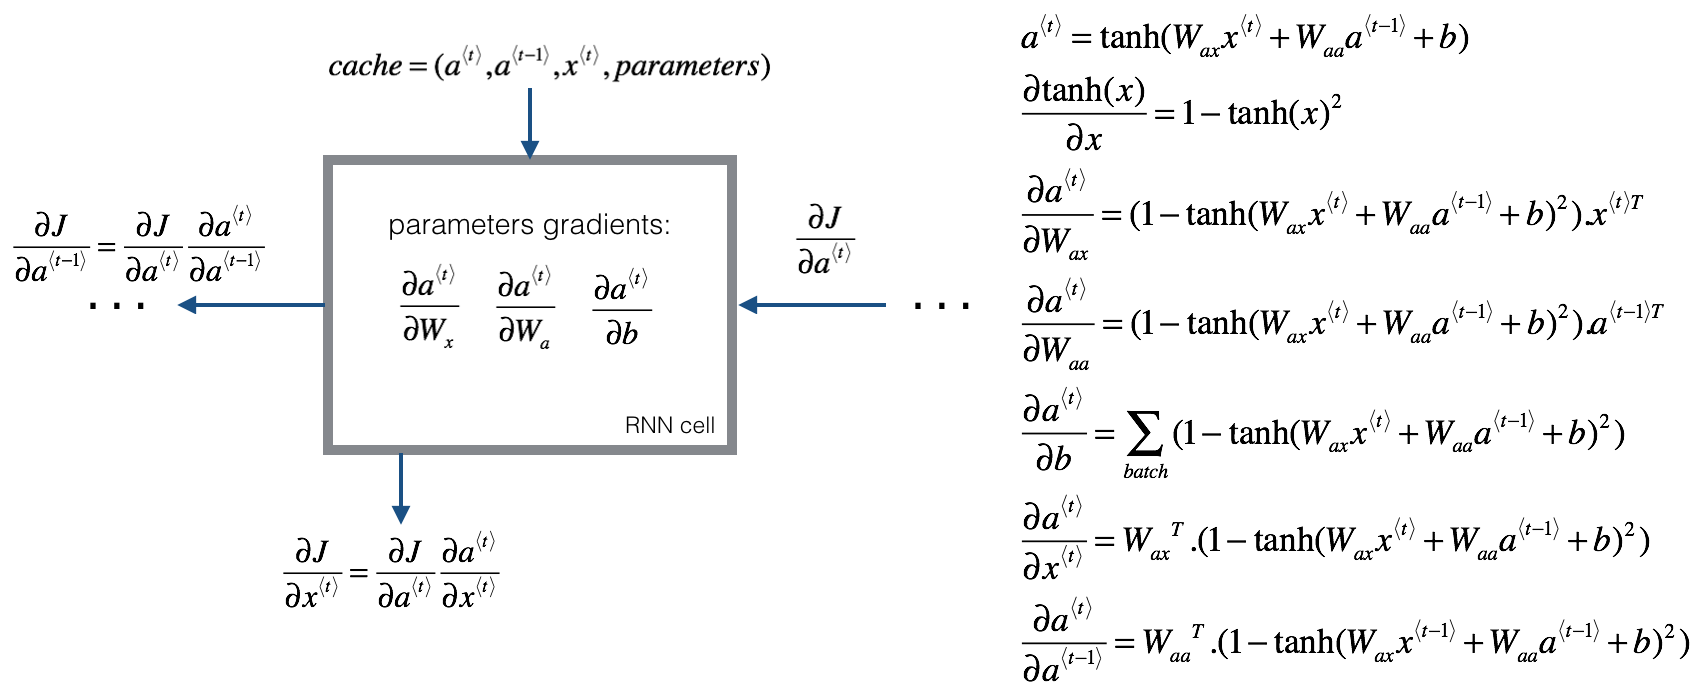

<caption><center>

**Gambar 5**: Back pass sel RNN. Sama seperti dalam *fully connected NN*, turunan dari *cost function* $J$ merambat kembali melalui RNN dengan mengikuti aturan rantai dari kalkulus. Aturan rantai juga digunakan untuk menghitung $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J} {\partial b})$ untuk update parameter $(W_{ax}, W_{aa}, b_a)$. 

</center></caption>

#### Menurunkan fungsi satu langkah mundur:

Untuk menghitung `rnn_cell_backward` Anda perlu menghitung persamaan berikut.

Turunan dari $\tanh$ adalah $1-\tanh(x)^2$. Anda dapat menemukan bukti lengkapnya [di sini](https://www.wyzant.com/resources/lessons/math/calculus/derivative_proofs/tanx). Perhatikan bahwa: $ \sec(x)^2 = 1 - \tanh(x)^2$

Demikian pula untuk $\frac{ \partial a^{\langle t \rangle} } {\partial W_{ax}}, \frac{ \partial a^{\langle t \rangle} } {\partial W_{aa}} , \frac{ \partial a^{\langle t \rangle} } {\partial b}$, turunan dari $\tanh(u)$ adalah $(1-\tanh(u)^2)du$.

Dua persamaan terakhir juga mengikuti aturan yang sama dan diturunkan menggunakan turunan $\tanh$. Perhatikan bahwa pengaturan dilakukan dengan cara untuk mendapatkan dimensi yang sama agar sesuai.

In [12]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    ### START TODO ###
    # compute the gradient of tanh with respect to a_next (≈1 line)
    dtanh = np.multiply(1 - np.multiply(a_next, a_next), da_next)

    # compute the gradient of the loss with respect to Wax (≈2 lines)
    dxt = np.matmul(Wax.T, dtanh)
    dWax = np.matmul(dtanh, xt.T)

    # compute the gradient with respect to Waa (≈2 lines)
    da_prev = np.matmul(Waa.T, dtanh)
    dWaa = np.matmul(dtanh, a_prev.T)

    # compute the gradient with respect to b (≈1 line)
    dba = np.sum(dtanh, 1, keepdims=True)

    ### END TODO ###
    
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [13]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
b = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

a_next, yt, cache = rnn_cell_forward(xt, a_prev, parameters)

da_next = np.random.randn(5,10)
gradients = rnn_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dxt"][1][2] = -0.4605641030588796
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = 0.08429686538067724
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.39308187392193034
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = -0.28483955786960663
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [0.80517166]
gradients["dba"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dxt"][1][2]</b>
        </td>
        <td>
           -0.460564103059
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dxt"].shape</b>
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"][2][3]</b>
        </td>
        <td>
           0.0842968653807
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"].shape</b>
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWax"][3][1]</b>
        </td>
        <td>
           0.393081873922
        </td>
    </tr>
            <tr>
        <td>
            <b>gradients["dWax"].shape</b>
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"][1][2]</b> 
        </td>
        <td>
           -0.28483955787
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"].shape</b>
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"][4]</b> 
        </td>
        <td>
           [ 0.80517166]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

#### Backward pass melewati RNN

Menghitung gradien dari *cost* sehubungan dengan $a^{\langle t \rangle}$ pada setiap langkah waktu $t$ berguna karena ini membantu gradien backpropagate ke sel RNN sebelumnya. Untuk melakukannya, Anda perlu mengulangi semua langkah waktu mulai dari akhir, dan pada setiap langkah, Anda menambah keseluruhan $db_a$, $dW_{aa}$, $dW_{ax}$ dan Anda menyimpan $dx$ .

**Petunjuk**:

Terapkan fungsi `rnn_backward`. Inisialisasi variabel kembalian dengan nol terlebih dahulu, lalu ulangi semua langkah waktu sambil memanggil `rnn_cell_backward` pada setiap langkah waktu, perbarui variabel lain yang sesuai.

In [14]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    ### START TODO ###
    
    # Retrieve values from the first cache (t=1) of caches (≈2 lines)
    caches, x = caches
    (a1, a0, x1, parameters) = caches[0]

    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x = x1.shape[0]
        
    # initialize the gradients with the right sizes (≈6 lines)
    dx = np.zeros(x.shape)
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
        
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step. (≈1 line)
        gradients = rnn_cell_backward(da[:, :, t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients (≈ 1 line)
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t (≈4 lines)
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps (≈1 line) 
    da0 = da[:, :, 0]
    ### END TODO ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [15]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
a, y, caches = rnn_forward(x, a0, parameters)
da = np.random.randn(5, 10, 4)
gradients = rnn_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.8677686776235903
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527775
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.303333126579894
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dx"][1][2]</b>
        </td>
        <td>
           [-2.07101689 -0.59255627  0.02466855  0.01483317]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dx"].shape</b>
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"][2][3]</b>
        </td>
        <td>
           -0.314942375127
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"].shape</b>
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            <b>gradients["dWax"][3][1]</b>
        </td>
        <td>
           11.2641044965
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWax"].shape</b>
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"][1][2]</b> 
        </td>
        <td>
           2.30333312658
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"].shape</b>
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"][4]</b> 
        </td>
        <td>
           [-0.74747722]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

## 3.2 - LSTM backward pass

### 3.2.1 One Step backward

Backward pass LSTM sedikit lebih rumit daripada forward pass. Kami telah memberi Anda semua persamaan untuk umpan balik LSTM di bawah ini. (Jika Anda menyukai latihan kalkulus, jangan ragu untuk mencoba melakukannya sendiri dari awal.)

### 3.2.2 Gate derivatives

$$d \Gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*(1-\Gamma_o^{\langle t \rangle})\tag{7}$$

$$d\tilde c^{\langle t \rangle} = (dc_{next}*\Gamma_i^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * i_t * da_{next}) * (1 - \tilde c^2) \tag{8}$$

$$d\Gamma_u^{\langle t \rangle} = (dc_{next}*\tilde c^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * \tilde c^{\langle t \rangle} * da_{next}*\Gamma_u^{\langle t \rangle})*(1-\Gamma_u^{\langle t \rangle})\tag{9}$$

$$d\Gamma_f^{\langle t \rangle} = (dc_{next}*\tilde c_{prev} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * c_{prev} * da_{next}*\Gamma_f^{\langle t \rangle})*(1-\Gamma_f^{\langle t \rangle})\tag{10}$$

### 3.2.3 Parameter derivatives 

$$ dW_f = d\Gamma_f^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{11} $$
$$ dW_u = d\Gamma_u^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{12} $$
$$ dW_c = d\tilde c^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{13} $$
$$ dW_o = d\Gamma_o^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{14}$$

Untuk menghitung $db_f, db_u, db_c, db_o$ Anda hanya perlu menjumlahkan seluruh sumbu horizontal (sumbu= 1) pada $d\Gamma_f^{\langle t \rangle}, d\Gamma_u^{\langle t \rangle} , d\tilde c^{\langle t \rangle}, d\Gamma_o^{\langle t \rangle}$ masing-masing. Perhatikan bahwa Anda harus memiliki opsi `keep_dims = True`.

Terakhir, Anda akan menghitung turunan sehubungan dengan *hidden state* sebelumnya, *state* memori sebelumnya, dan input.

$$ da_{prev} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c^{\ langle t \rangle} + W_o^T * d\Gamma_o^{\langle t \rangle} \tag{15}$$
Di sini, bobot untuk persamaan 13 adalah n_a pertama, (yaitu $W_f = W_f[:n_a,:]$ dll...)

$$ dc_{prev} = dc_{next}\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh(c_{next})^2)*\Gamma_f ^{\langle t \rangle}*da_{next} \tag{16}$$
$$ dx^{\langle t \rangle} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\ tilde c_t + W_o^T * d\Gamma_o^{\langle t \rangle}\tag{17} $$
di mana bobot untuk persamaan 15 adalah dari n_a sampai akhir, (yaitu $W_f = W_f[n_a:,:]$ dll...)

**Latihan:** Terapkan `lstm_cell_backward` dengan menerapkan persamaan $7-17$ di bawah. Semoga berhasil! :)

In [16]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    ### START TODO ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_a, m = a_next.shape
    n_x = xt.shape[0]
    
    # Compute gates related derivatives, you can find their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * it + ot * (1 - np.tanh(c_next) ** 2) * it * da_next) * (1 - cct ** 2)
    dit = (dc_next * cct + ot * (1 - np.tanh(c_next) ** 2) * cct * da_next) * it * (1 - it)
    dft = (dc_next * c_prev + ot * (1 - np.tanh(c_next) ** 2) * c_prev * da_next) * ft * (1 - ft)

    # Compute parameters related derivatives. Use equations (11)-(14) (≈8 lines)
    concat_ax = np.concatenate((a_prev, xt)).T
    dWf = np.matmul(dft, concat_ax)
    dWi = np.matmul(dit, concat_ax)
    dWc = np.matmul(dcct, concat_ax)
    dWo = np.matmul(dot, concat_ax)
    dbf = np.sum(dft, axis=1, keepdims=True)
    dbi = np.sum(dit, axis=1, keepdims=True)
    dbc = np.sum(dcct, axis=1, keepdims=True)
    dbo = np.sum(dot, axis=1, keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17). (≈3 lines)
    WfT = parameters["Wf"][:, :n_a].T
    WiT = parameters["Wi"][:, :n_a].T
    WcT = parameters["Wc"][:, :n_a].T
    WoT = parameters["Wo"][:, :n_a].T
    da_prev = np.matmul(WfT, dft) + np.matmul(WiT, dit) + np.matmul(WcT, dcct) + np.matmul(WoT, dot)
    dc_prev = dc_next * ft + ot * (1 - np.tanh(c_next) ** 2) * ft * da_next

    WfT = parameters["Wf"][:, n_a:].T
    WiT = parameters["Wi"][:, n_a:].T
    WcT = parameters["Wc"][:, n_a:].T
    WoT = parameters["Wo"][:, n_a:].T
    dxt = np.matmul(WfT, dft) + np.matmul(WiT, dit) + np.matmul(WcT, dcct) + np.matmul(WoT, dot)
    ### END TODO ###
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [17]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)

da_next = np.random.randn(5,10)
dc_next = np.random.randn(5,10)
gradients = lstm_cell_backward(da_next, dc_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dxt"][1][2] = 3.2305591151091875
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.06396214197109236
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.7975220387970015
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.1479548381644968
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.0574980552259903
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.3045621636876668
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.3313115952892109
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [0.13893342]
gradients["dbo"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dxt"][1][2]</b>
        </td>
        <td>
           3.23055911511
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dxt"].shape</b>
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"][2][3]</b>
        </td>
        <td>
           -0.0639621419711
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"].shape</b>
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            <b>gradients["dc_prev"][2][3]</b>
        </td>
        <td>
           0.797522038797
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dc_prev"].shape</b>
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"][3][1]</b> 
        </td>
        <td>
           -0.147954838164
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"].shape</b>
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"][1][2]</b> 
        </td>
        <td>
           1.05749805523
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"].shape</b> 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWc"][3][1]</b> 
        </td>
        <td>
           2.30456216369
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWc"].shape</b> 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWo"][1][2]</b> 
        </td>
        <td>
           0.331311595289
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWo"].shape</b> 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbf"][4]</b> 
        </td>
        <td>
           [ 0.18864637]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbf"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbi"][4]</b> 
        </td>
        <td>
           [-0.40142491]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbi"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"][4]</b> 
        </td>
        <td>
           [ 0.25587763]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"][4]</b> 
        </td>
        <td>
           [ 0.13893342]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

### 3.3 Backward pass through the LSTM RNN

Bagian ini sangat mirip dengan fungsi `rnn_backward` yang Anda terapkan di atas. Pertama-tama Anda akan membuat variabel dengan dimensi yang sama dengan variabel hasil Anda. Anda kemudian akan mengulangi semua langkah waktu mulai dari akhir dan memanggil fungsi satu langkah yang Anda terapkan untuk LSTM di setiap iterasi. Anda kemudian akan update parameter dengan cara meng-sum satu per satu. Akhirnya return dictionary dengan gradien baru.

**Petunjuk**: Menerapkan fungsi `lstm_backward`. Buat loop for mulai dari $T_x$ dan mundur. Untuk setiap langkah, panggil `lstm_cell_backward` dan update gradien lama Anda dengan menambahkan gradien baru ke dalamnya. Perhatikan bahwa `dxt` tidak diperbarui tetapi disimpan.

In [18]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    dc -- Gradients w.r.t the memory states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    ### START TODO ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x = x1.shape[0]
    
    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:, :, t], dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[: ,: ,t] = gradients["dxt"]
        # da_prevt = gradients["da_prev"]
        # dc_prevt = gradients["dc_prev"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
    
    ### END TODO ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [19]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)

da = np.random.randn(5, 10, 4)
gradients = lstm_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dx"][1][2] = [-0.00173313  0.08287442 -0.30545663 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.09591150195400468
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.06981985612744011
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.10237182024854777
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.06249837949274524
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.04843891314443014
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.0565788]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.15399065]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.29691142]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.29798344]
gradients["dbo"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dx"][1][2]</b>
        </td>
        <td>
           [-0.00173313  0.08287442 -0.30545663 -0.43281115]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dx"].shape</b>
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"][2][3]</b>
        </td>
        <td>
           -0.095911501954
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"].shape</b>
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"][3][1]</b> 
        </td>
        <td>
           -0.0698198561274
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"].shape</b>
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"][1][2]</b> 
        </td>
        <td>
           0.102371820249
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"].shape</b> 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWc"][3][1]</b> 
        </td>
        <td>
           -0.0624983794927
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWc"].shape</b> 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWo"][1][2]</b> 
        </td>
        <td>
           0.0484389131444
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWo"].shape</b> 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbf"][4]</b> 
        </td>
        <td>
           [-0.0565788]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbf"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbi"][4]</b> 
        </td>
        <td>
           [-0.06997391]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbi"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"][4]</b> 
        </td>
        <td>
           [-0.27441821]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"][4]</b> 
        </td>
        <td>
           [ 0.16532821]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"].shape</b> 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>